In [2]:
import os
import pandas as pd
import sys
import torch
from torch.utils.data import DataLoader as TorchDataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

# --- Añadir la carpeta raíz al path para encontrar la carpeta 'src' ---
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Añadido al path: {project_root}")

# --- IMPORTAMOS NUESTRA ARQUITECTURA ---
from src.architecture import Dataset, collate_fn, Model, fit

# --- Configuración del Dispositivo ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Usando dispositivo: cuda


# ##############################

In [3]:
# --- Rutas de Datos ---
RAW_DATA_PATH = "../data/raw/color"
PROCESSED_DATA_PATH = "../data/processed/"

# --- Carga de DataFrames ---
df_strat1 = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'train_strategy_1.csv'))
df_strat2 = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'train_strategy_2.csv'))
df_full_splitted = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv'))

# --- Preparar DataFrames de train/valid ---
df_train_original = df_full_splitted[df_full_splitted['split'] == 'train'].copy()
df_train_original['image_path'] = df_train_original['relative_path'].apply(lambda rel_path: os.path.join(RAW_DATA_PATH, rel_path))

df_valid = df_full_splitted[df_full_splitted['split'] == 'valid'].copy()
df_valid['image_path'] = df_valid['relative_path'].apply(lambda rel_path: os.path.join(RAW_DATA_PATH, rel_path))

# --- Mapeo de Clases y Transformación ---
all_classes = sorted(df_full_splitted['class'].unique())
label_map = {label: i for i, label in enumerate(all_classes)}
NUM_CLASSES = len(all_classes)
data_transform = transforms.Compose([transforms.Resize((224, 224))])

# --- Crear Datasets ---
dataset_original = Dataset(df_train_original['image_path'].values, df_train_original['class'].values, label_map, trans=data_transform)
dataset_s1 = Dataset(df_strat1['image_path'].values, df_strat1['class'].values, label_map, trans=data_transform)
dataset_s2 = Dataset(df_strat2['image_path'].values, df_strat2['class'].values, label_map, trans=data_transform)
dataset_valid = Dataset(df_valid['image_path'].values, df_valid['class'].values, label_map, trans=data_transform)

# --- Crear DataLoaders ---
dataloader_original = {'train': TorchDataLoader(dataset_original, batch_size=32, shuffle=True, collate_fn=collate_fn),
                       'valid': TorchDataLoader(dataset_valid, batch_size=64, shuffle=False, collate_fn=collate_fn)}

dataloader_s1 = {'train': TorchDataLoader(dataset_s1, batch_size=32, shuffle=True, collate_fn=collate_fn),
                 'valid': TorchDataLoader(dataset_valid, batch_size=64, shuffle=False, collate_fn=collate_fn)}

dataloader_s2 = {'train': TorchDataLoader(dataset_s2, batch_size=32, shuffle=True, collate_fn=collate_fn),
                 'valid': TorchDataLoader(dataset_valid, batch_size=64, shuffle=False, collate_fn=collate_fn)}

print(f"DataLoaders creados. Muestras en Train Original: {len(dataset_original)}, Estrategia 1: {len(dataset_s1)}, Estrategia 2: {len(dataset_s2)}")

DataLoaders creados. Muestras en Train Original: 38013, Estrategia 1: 93673, Estrategia 2: 60923


In [6]:
import torchvision
from torchsummary import summary
resnet = torchvision.models.resnet18()
summary(resnet, (3, 224, 224)) 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

In [4]:
results = {}
EPOCHS = 15
LR = 1e-3
PATIENCE = 3

# ===================================================================
# --- GRUPO DE EXPERIMENTOS PARA ESTRATEGIA 1 ---
# ===================================================================
print("="*50)
print("INICIANDO GRUPO DE EXPERIMENTOS PARA ESTRATEGIA 1")
print("="*50)

# 1. Baseline para Estrategia 1 (Desde Cero)
model_s1_base = Model(num_classes=NUM_CLASSES, pretrained=False)
results['Estrategia 1 (Baseline)'] = fit(
    model=model_s1_base, 
    dataloader=dataloader_s1,
    epochs=EPOCHS, lr=LR, patience=PATIENCE, 
    model_name='Strat1_Baseline', device=DEVICE
)

# 2. Transfer Learning para Estrategia 1
model_s1_tl = Model(num_classes=NUM_CLASSES, pretrained=True)
model_s1_tl.freeze()
results['Estrategia 1 (Transfer Learning)'] = fit(
    model=model_s1_tl, 
    dataloader=dataloader_s1,
    epochs=EPOCHS, lr=LR, patience=PATIENCE, 
    model_name='Strat1_TransferLearning', device=DEVICE
)


# ===================================================================
# --- GRUPO DE EXPERIMENTOS PARA ESTRATEGIA 2 ---
# ===================================================================
print("\n" * 2 + "="*50)
print("INICIANDO GRUPO DE EXPERIMENTOS PARA ESTRATEGIA 2")
print("="*50)

# 3. Baseline para Estrategia 2 (Desde Cero)
model_s2_base = Model(num_classes=NUM_CLASSES, pretrained=False)
results['Estrategia 2 (Baseline)'] = fit(
    model=model_s2_base, 
    dataloader=dataloader_s2,
    epochs=EPOCHS, lr=LR, patience=PATIENCE, 
    model_name='Strat2_Baseline', device=DEVICE
)

# 4. Transfer Learning para Estrategia 2
model_s2_tl = Model(num_classes=NUM_CLASSES, pretrained=True)
model_s2_tl.freeze()
results['Estrategia 2 (Transfer Learning)'] = fit(
    model=model_s2_tl, 
    dataloader=dataloader_s2,
    epochs=EPOCHS, lr=LR, patience=PATIENCE, 
    model_name='Strat2_TransferLearning', device=DEVICE
)


INICIANDO GRUPO DE EXPERIMENTOS PARA ESTRATEGIA 1

--- Entrenando Strat1_Baseline por un máximo de 15 epochs (Paciencia: 3) ---


Epoch 1/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 1/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 2/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 2/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 3/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 3/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 4/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 4/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 5/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 5/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: No hubo mejora. Contador de paciencia: 1/3


Epoch 6/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 6/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 7/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 7/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 8/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 8/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8: No hubo mejora. Contador de paciencia: 1/3


Epoch 9/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 9/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9: No hubo mejora. Contador de paciencia: 2/3


Epoch 10/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 10/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 11/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 11/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11: No hubo mejora. Contador de paciencia: 1/3


Epoch 12/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 12/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12: No hubo mejora. Contador de paciencia: 2/3


Epoch 13/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 13/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 14/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 14/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_Baseline_best.pth'


Epoch 15/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 15/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15: No hubo mejora. Contador de paciencia: 1/3
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat1_Baseline_best.pth'
Congelando capas convolucionales (Transfer Learning)...

--- Entrenando Strat1_TransferLearning por un máximo de 15 epochs (Paciencia: 3) ---


Epoch 1/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 1/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 2/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 2/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 3/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 3/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 4/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 4/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 5/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 5/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 6/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 6/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 7/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 7/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 8/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 8/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 9/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 9/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 10/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 10/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 11/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 11/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 12/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 12/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 13/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 13/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 14/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 14/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'


Epoch 15/15 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 15/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TransferLearning_best.pth'
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat1_TransferLearning_best.pth'


INICIANDO GRUPO DE EXPERIMENTOS PARA ESTRATEGIA 2

--- Entrenando Strat2_Baseline por un máximo de 15 epochs (Paciencia: 3) ---


Epoch 1/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 1/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 2/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 2/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 3/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 3/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 4/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 4/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: No hubo mejora. Contador de paciencia: 1/3


Epoch 5/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 5/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: No hubo mejora. Contador de paciencia: 2/3


Epoch 6/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 6/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 7/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 7/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 8/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 8/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 9/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 9/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 10/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 10/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 11/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 11/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 12/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 12/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12: No hubo mejora. Contador de paciencia: 1/3


Epoch 13/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 13/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13: No hubo mejora. Contador de paciencia: 2/3


Epoch 14/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 14/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'


Epoch 15/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 15/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_Baseline_best.pth'
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat2_Baseline_best.pth'
Congelando capas convolucionales (Transfer Learning)...

--- Entrenando Strat2_TransferLearning por un máximo de 15 epochs (Paciencia: 3) ---


Epoch 1/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 1/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 2/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 2/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 3/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 3/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 4/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 4/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 5/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 5/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 6/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 6/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 7/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 7/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 8/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 8/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 9/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 9/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 10/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 10/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 11/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 11/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 12/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 12/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 13/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 13/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 14/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 14/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'


Epoch 15/15 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 15/15 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TransferLearning_best.pth'
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat2_TransferLearning_best.pth'


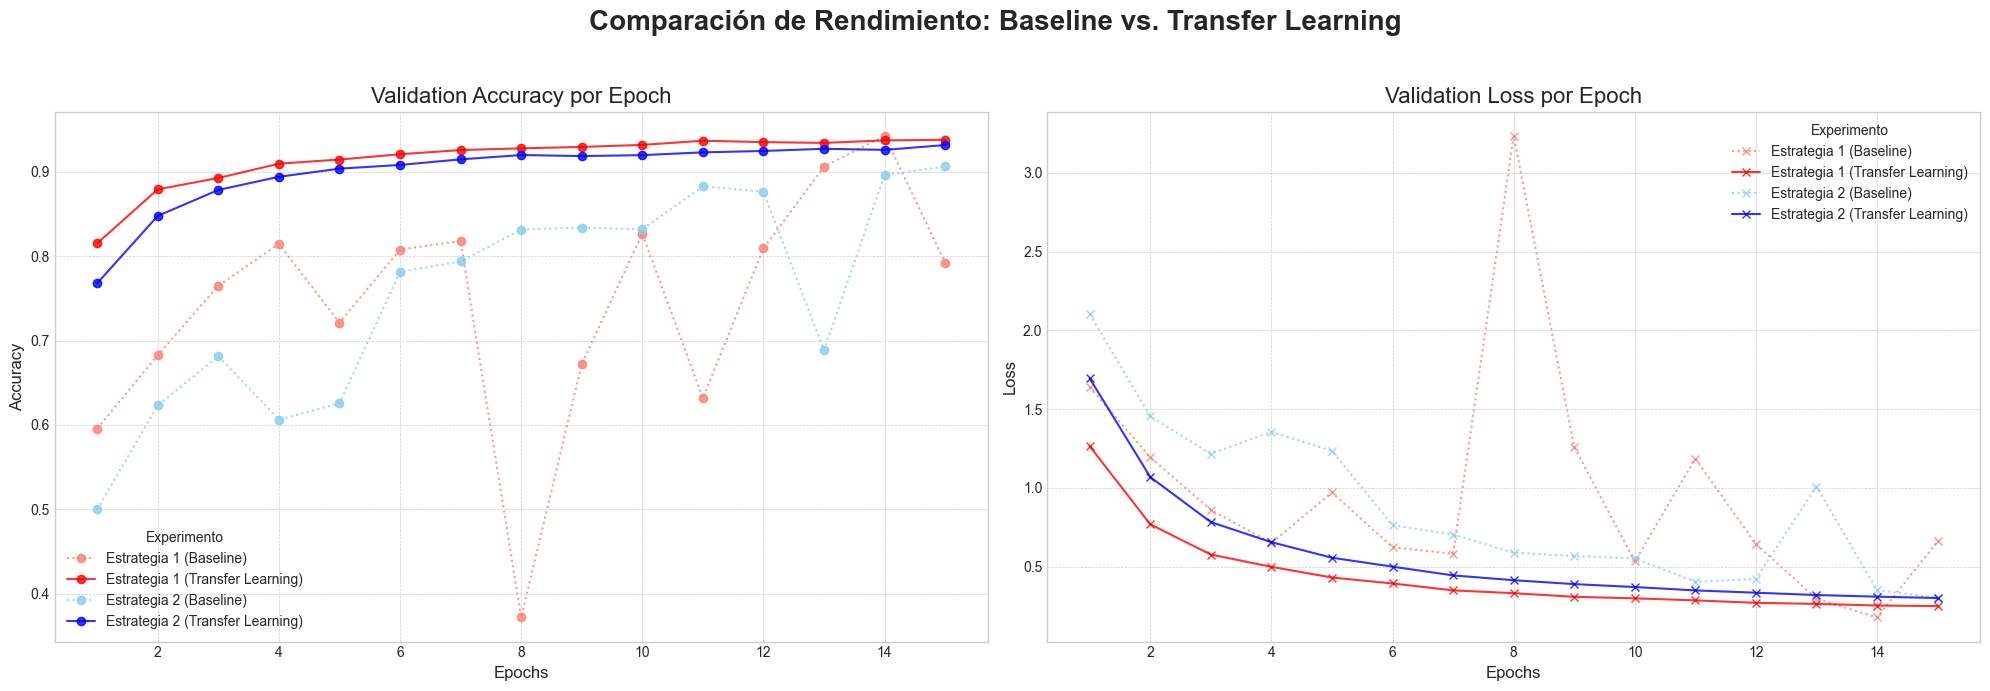

In [5]:
if 'results' in locals() and results:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle("Comparación de Rendimiento: Baseline vs. Transfer Learning", fontsize=20, weight='bold')

    # Paleta de colores para comparar estrategias y técnicas
    colors = {
        'Estrategia 1 (Baseline)': 'salmon',
        'Estrategia 1 (Transfer Learning)': 'red',
        'Estrategia 2 (Baseline)': 'skyblue',
        'Estrategia 2 (Transfer Learning)': 'blue'
    }
    
    # Estilos de línea para diferenciar Baseline de Transfer Learning
    linestyles = {
        'Estrategia 1 (Baseline)': ':',
        'Estrategia 1 (Transfer Learning)': '-',
        'Estrategia 2 (Baseline)': ':',
        'Estrategia 2 (Transfer Learning)': '-'
    }

    # --- Gráfico 1: Validation Accuracy ---
    ax = axes[0]
    for name, history in results.items():
        if history['val_acc']:
            ax.plot(range(1, len(history['val_acc']) + 1), 
                    history['val_acc'], 
                    label=name, 
                    color=colors.get(name, 'black'),
                    linestyle=linestyles.get(name, '-'),
                    marker='o',
                    alpha=0.8)
    ax.set_title("Validation Accuracy por Epoch", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.legend(title="Experimento")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Gráfico 2: Validation Loss ---
    ax = axes[1]
    for name, history in results.items():
        if history['val_loss']:
            ax.plot(range(1, len(history['val_loss']) + 1), 
                    history['val_loss'], 
                    label=name, 
                    color=colors.get(name, 'black'),
                    linestyle=linestyles.get(name, '-'),
                    marker='x',
                    alpha=0.8)
    ax.set_title("Validation Loss por Epoch", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.legend(title="Experimento")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("La variable 'results' no contiene datos. Asegúrate de ejecutar las celdas de entrenamiento primero.")